**Step 1: Load Libraries and Data**

In [30]:
#!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE

Load the dataset

In [3]:
data = pd.read_csv('Fraud.csv')

 Display the first few rows of the dataset

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


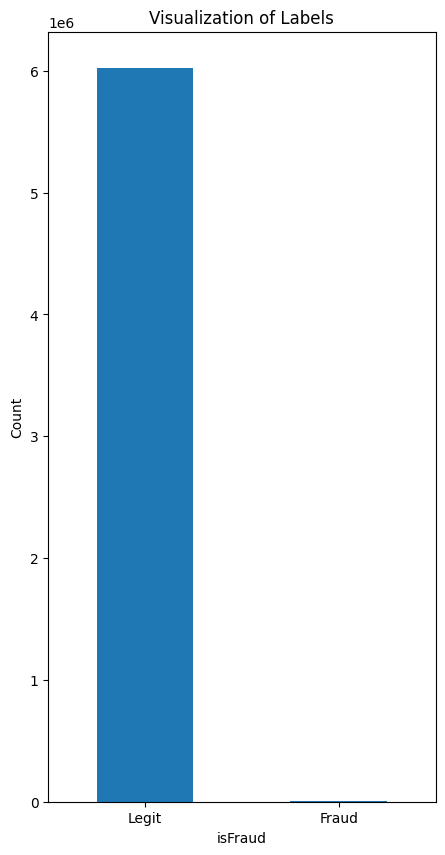

In [31]:
plt.figure(figsize=(5, 10))
labels = ["Legit", "Fraud"]
count_classes = data['isFraud'].value_counts(sort=True)
count_classes.plot(kind="bar", rot=0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

**Step 2: Data Cleaning**

Check for missing values

In [5]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Since there are no missing values, let's move to outlier detection

Text(0.5, 1.0, 'Boxplot of Transaction Amounts')

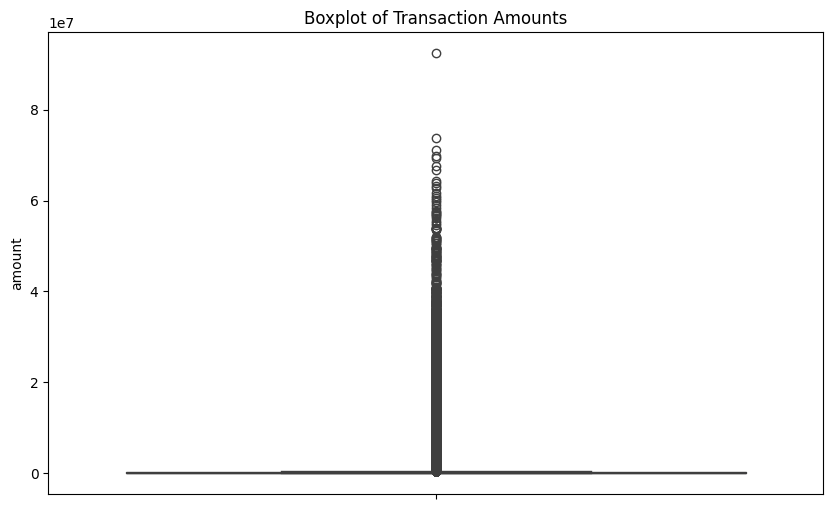

In [6]:
plt.figure(figsize=(10,6))
sns.boxplot(data['amount'])
plt.title('Boxplot of Transaction Amounts')

Remove outliers using IQR method

In [7]:
Q1 = data['amount'].quantile(0.25)
Q3 = data['amount'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['amount'] < (Q1 - 1.5 * IQR)) |(data['amount'] > (Q3 + 1.5 * IQR)))]

Check for multicollinearity

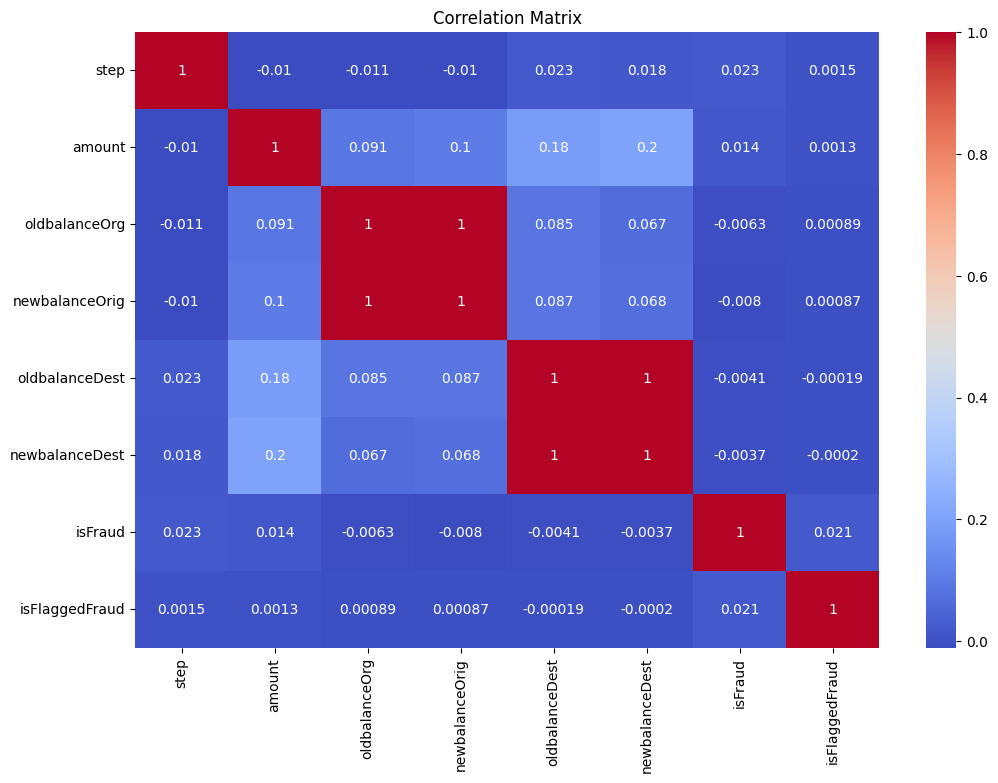

In [9]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
corr_matrix = data[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Step 3: Feature Engineering**

Create new features and prepare the data for modeling

In [10]:
# Create new features based on existing columns
data['errorBalanceOrig'] = data['newbalanceOrig'] + data['amount'] - data['oldbalanceOrg']
data['errorBalanceDest'] = data['oldbalanceDest'] + data['amount'] - data['newbalanceDest']

In [11]:
# Convert categorical variable 'type' to dummy variables
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [12]:
# Select features and target variable
X = data.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = data['isFraud']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Step 4: Model Building**

In [15]:
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Get indices of the top 10 important features

# Select the top 10 important features
X_train_rfe = X_train[:, indices]
X_test_rfe = X_test[:, indices]

# List of selected features
selected_features = X.columns[indices]
print("Selected features: ", selected_features)

Selected features:  Index(['type_CASH_OUT', 'amount', 'oldbalanceOrg', 'type_TRANSFER', 'step',
       'oldbalanceDest', 'errorBalanceDest', 'newbalanceDest',
       'errorBalanceOrig', 'newbalanceOrig'],
      dtype='object')


In [19]:
# Train the model
model.fit(X_train_rfe, y_train)

RandomForestClassifier(random_state=42)

**Step 5: Model Evaluation**

In [20]:
# Predict the test set
y_pred = model.predict(X_test_rfe)
y_prob = model.predict_proba(X_test_rfe)[:,1]


In [21]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1806059       3]
 [     10    1291]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1806062
           1       1.00      0.99      0.99      1301

    accuracy                           1.00   1807363
   macro avg       1.00      1.00      1.00   1807363
weighted avg       1.00      1.00      1.00   1807363



In [22]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC-AUC Score: {roc_auc}')

ROC-AUC Score: 0.9965384516448347


In [27]:
from sklearn.model_selection import cross_val_score
import random

# Sample a smaller subset of the data
sample_fraction = 0.1  # Use 10% of the data for cross-validation
X_train_sample, y_train_sample = X_train_rfe, y_train
if len(X_train_rfe) > 100000:
    sample_indices = random.sample(range(len(X_train_rfe)), k=int(sample_fraction * len(X_train_rfe)))
    X_train_sample = X_train_rfe[sample_indices]
    y_train_sample = y_train.iloc[sample_indices]

# Perform cross-validation with 3 folds
cv_scores = cross_val_score(model, X_train_sample, y_train_sample, cv=3, scoring='roc_auc', n_jobs=-1)
print(f'Cross-Validation AUC Scores: {cv_scores}')
print(f'Mean AUC Score: {cv_scores.mean()}')

Cross-Validation AUC Scores: [1.         0.99999986 1.        ]
Mean AUC Score: 0.9999999539222753


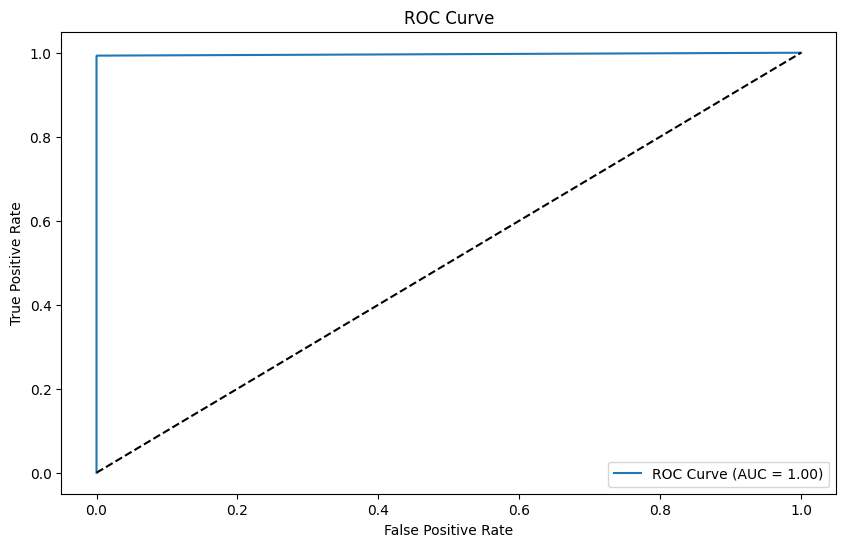

In [23]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Step 6: Key Factors and Insights**

In [25]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index=selected_features,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Display the feature importances
print("Feature Importances:\n", feature_importances)


Feature Importances:
                   importance
newbalanceOrig      0.445227
errorBalanceOrig    0.254913
newbalanceDest      0.105380
errorBalanceDest    0.054395
oldbalanceDest      0.043161
step                0.037667
type_TRANSFER       0.022318
oldbalanceOrg       0.020627
amount              0.013323
type_CASH_OUT       0.002988
